In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import time
import random

2024-08-23 17:29:58.851755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 17:29:58.869902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 17:29:58.874552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 17:29:58.886738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 17:29:59.981913: W tensorflow/compiler/tf2

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


In [3]:
# set seed
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

### Load the data

In [4]:
# file_name = 'movenet_thunder_mobilenet_small'
# file_name = 'movenet_lightning_mobilenet_large'
# file_name = 'movenet_thunder_mobilenet_large'
# file_name = 'movenet_lightning_mobilenet_small'

In [5]:
file_name = "movenet_thunder_mobilenet_large"

In [6]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [7]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [8]:
# shape of the data
print('keypoints shape: ', df['keypoints'].iloc[0].shape)
print('object shape: ', df['object'].iloc[0].shape)
print('obj_vector shape: ', df['obj_vector'].iloc[0].shape)

keypoints shape:  (51,)
object shape:  (5, 1)
obj_vector shape:  (5, 100)


In [9]:
# set to 0 the keypoints with score < 0.3
def filter_keypoints(x):
    x[x[:, 2] < 0.3] = 0
    return x

# df['keypoints'] = df['keypoints'].apply(lambda x: filter_keypoints(x))

# keep only the positions of the keypoints
def get_positions(x):
    return x[:, :2]

# df['keypoints'] = df['keypoints'].apply(lambda x: get_positions(x))

# set to 0 the object with score < 0.1
def filter_object(x):
    x[x[:, 0] < 0.1] = 0
    return x

# df['object'] = df['object'].apply(lambda x: filter_object(x))

In [10]:
# number of object to consider
n_objects = 5

In [11]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object'][-n_objects:]
                                            *x['obj_vector'][-n_objects:], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [12]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.30178800225257874, 0.9912914037704468, 0.80...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.04209192469716072, 0.7099579572677612, 0.58...","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.051420778036117554, 0.4904737174510956, 0.5...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2283279001712799, 0.42992380261421204, 0.62...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Training-Test split

In [13]:
def train_test_split_df(df, test_perc): 

    n_classes = df['category'].nunique()
    n_samples = int(len(df)*test_perc/n_classes)
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'
    train_df = df[~df['filename'].isin(test_df['filename'])]

    return train_df, test_df

In [14]:
train_df, test_df = train_test_split_df(df, 0.2)

### Tensorflow Dataset

In [15]:
def create_dataset(df, batch_size, use_object=True, use_kpoints=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    if use_object and use_kpoints:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    elif use_kpoints:
        df['input'] = df['keypoints']
    elif use_object:
        df['input'] = df['obj_input']
    else:
        print('error: no input selected')
        return
    
    input_shape = df['input'].iloc[0].shape

    data = np.zeros((len(kpoints), input_shape[0]), dtype=np.float32)
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row).astype(np.float32)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset, input_shape

### Define the model

In [16]:
#BEST ONE
def create_model(input_shape, summary=False):
    
    model = tf.keras.Sequential([
            tf.keras.Input(shape=input_shape),
            tf.keras.layers.Dense(128, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='leaky_relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(32, activation='leaky_relu'),
            tf.keras.layers.Dense(15, activation='softmax')
        ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    if summary:
        model.summary()
    
    return model

In [17]:
model = create_model((1,), summary=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,815 (128.18 KB)

 Trainable params: 32,815 (128.18 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def plot_train(results):
    
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']
    
    t = np.arange(len(train_accuracy))
    
    print('Stopped at epoch ', len(train_accuracy))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [19]:
use_object = True
use_kpoints = True

Starting Fold Number  1

Fitting the model:

Training time:  22.38  s
Stopped at epoch  40


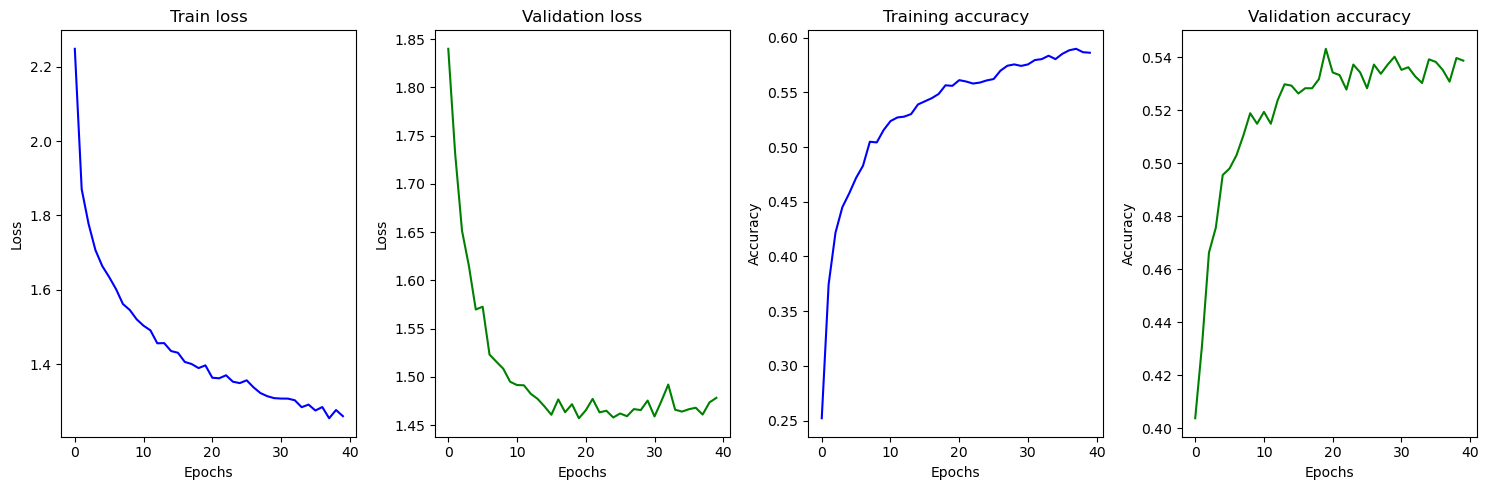

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5454 - loss: 1.4589

-----------------------------------------------------------------

Starting Fold Number  2



2024-08-23 17:30:27.482637: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  54.63  s
Stopped at epoch  94


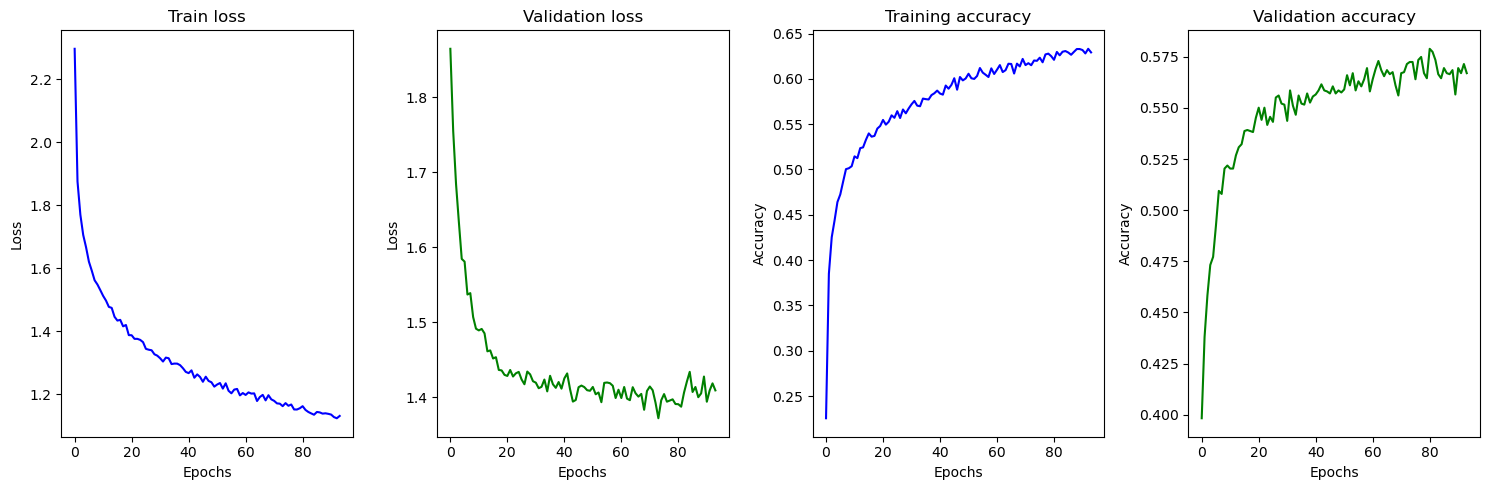

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5630 - loss: 1.4072

-----------------------------------------------------------------

Starting Fold Number  3



2024-08-23 17:31:23.063074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  33.82  s
Stopped at epoch  61


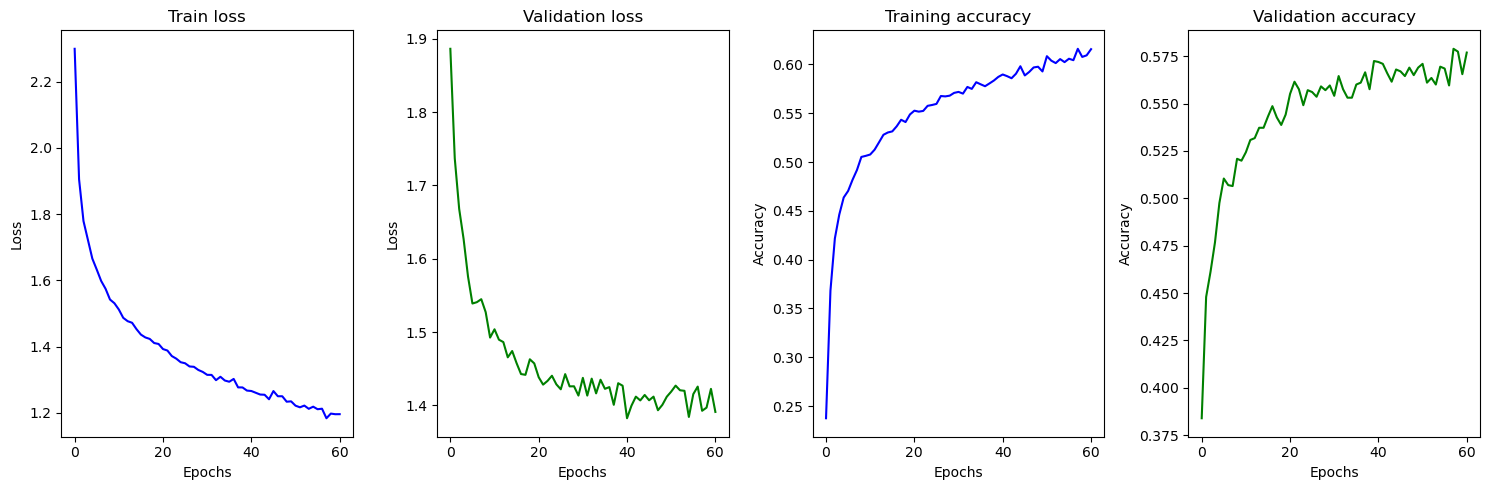

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5721 - loss: 1.4204

-----------------------------------------------------------------

Starting Fold Number  4

Fitting the model:

Training time:  40.28  s
Stopped at epoch  74


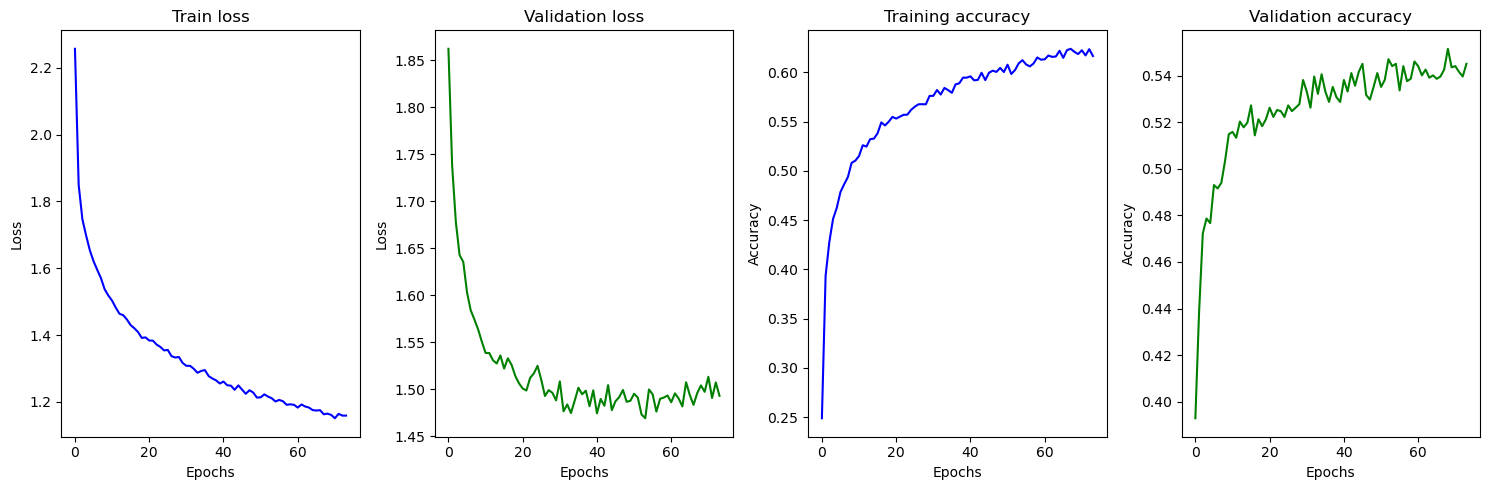

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5500 - loss: 1.4688  

-----------------------------------------------------------------

Starting Fold Number  5



2024-08-23 17:32:38.914929: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fitting the model:

Training time:  51.38  s
Stopped at epoch  91


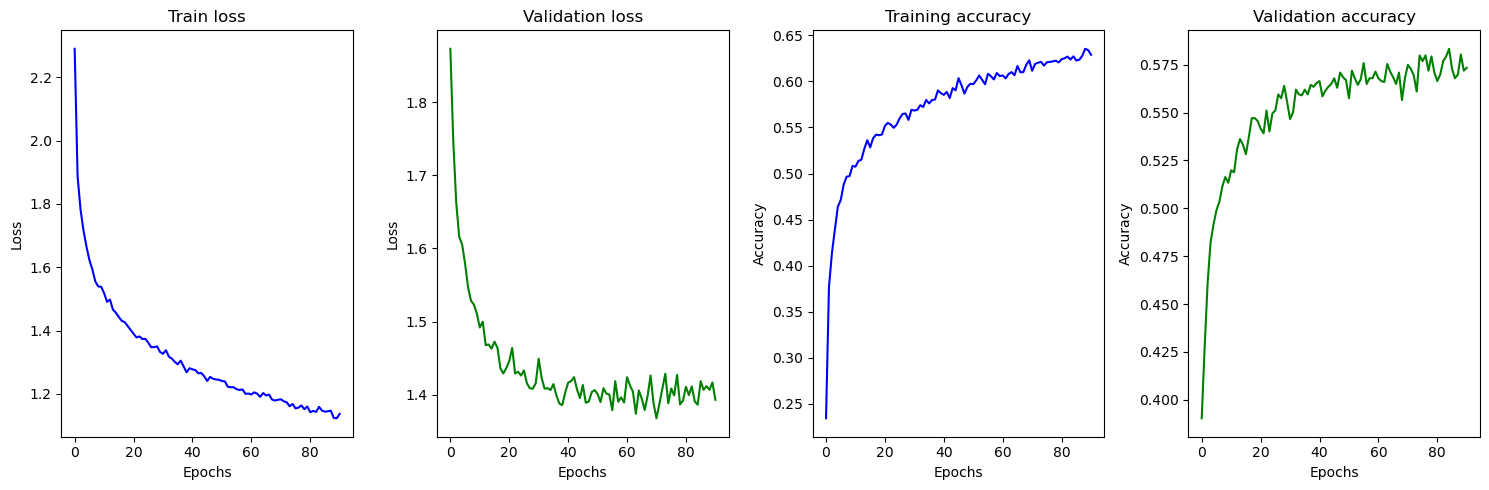

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5742 - loss: 1.3956

-----------------------------------------------------------------



In [20]:
# Number of folds
model_selection = True
if model_selection:
    n_splits = 5
    batch_s = 32
    index = 1

    # KFold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_per_fold = []
    conf_matrix = np.zeros((15,15))

    epochs_per_fold = []

    for train_index, val_index in kf.split(train_df):
        
        print("Starting Fold Number ", index)
        print()
        
        index += 1      
        
        df_train, df_val = train_df.iloc[train_index], train_df.iloc[val_index]
        
        # Convert to TensorFlow datasets
        train_dataset, inp_shape = create_dataset(df_train, batch_s, use_kpoints=use_kpoints, use_object=use_object)
        val_dataset, _ = create_dataset(df_val, batch_s, use_kpoints=use_kpoints, use_object=use_object)
        
        print("Fitting the model:")
        print()
        
        start = time.time()
        
        # Create a new instance of the model
        model = create_model(input_shape=inp_shape)
        
        early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

        results = model.fit(train_dataset,
                            epochs=1000,
                            validation_data=val_dataset, 
                            callbacks=[early_stop_callback], verbose = 0)
        
        epochs = len(results.history['loss'])
        epochs_per_fold.append(epochs)

        end = time.time()
        print('Training time: ', round(end-start,2), " s")
        
        plot_train(results)
        
        # compute predicted labels
        output_vector = model.predict(val_dataset)
        predicted_labels = np.argmax(output_vector[:,:], axis=1)

        extracted_labels = []
        for _, label in val_dataset:
            extracted_labels.extend(label.numpy().tolist())

        true_labels = np.array(extracted_labels)
        
        # compute the confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        #print(cm)
        conf_matrix = conf_matrix + cm
        
        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(val_dataset)
        accuracy_per_fold.append(val_accuracy)
        
        print()
        print('-----------------------------------------------------------------')
        print()

    avg_epochs = np.mean(epochs_per_fold)
else:
    avg_epochs = 48

### Analyze the results

In [21]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [22]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_title("Neural Network")
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

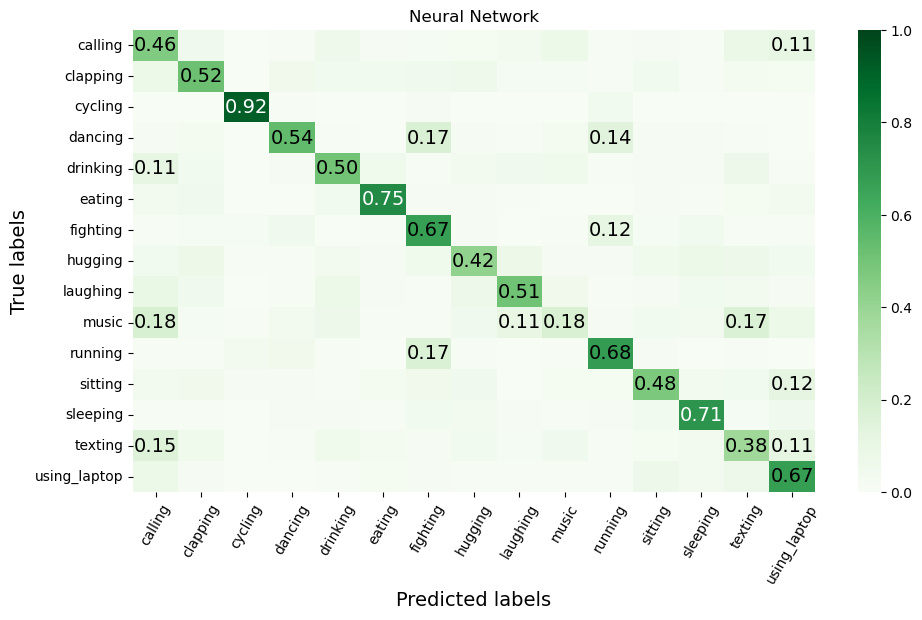

In [23]:
if model_selection:
    plot_confusion_matrix(conf_matrix)

In [24]:
def class_specific_metrics(cm, class_labels = labels):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [25]:
if model_selection:
    val_metrics = class_specific_metrics(conf_matrix)
    val_metrics

### Fit of the selected model on the training set

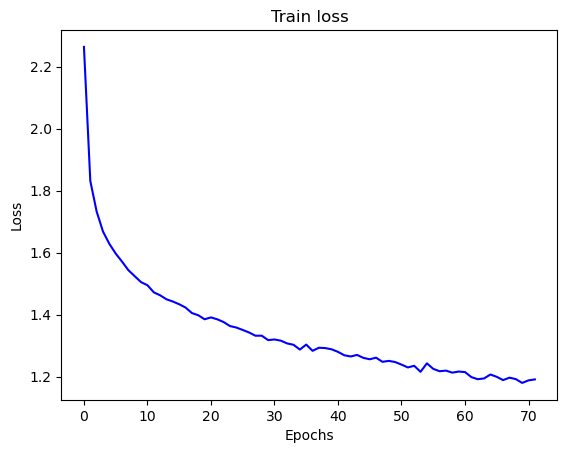

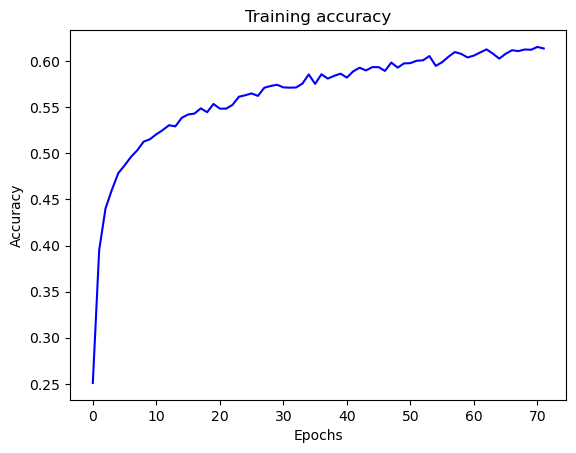

In [26]:
# fit the model on the whole training set
batch_s = 32
train_dataset, inp_shape = create_dataset(train_df, batch_s, use_kpoints=use_kpoints, use_object=use_object)

model = create_model(input_shape=inp_shape)

results = model.fit(train_dataset,
                    epochs=int(avg_epochs), verbose=0)

train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

plt.plot(train_loss, 'b')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(train_accuracy, 'b')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Test 

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5722 - loss: 1.4219 
Test accuracy: 0.5663
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


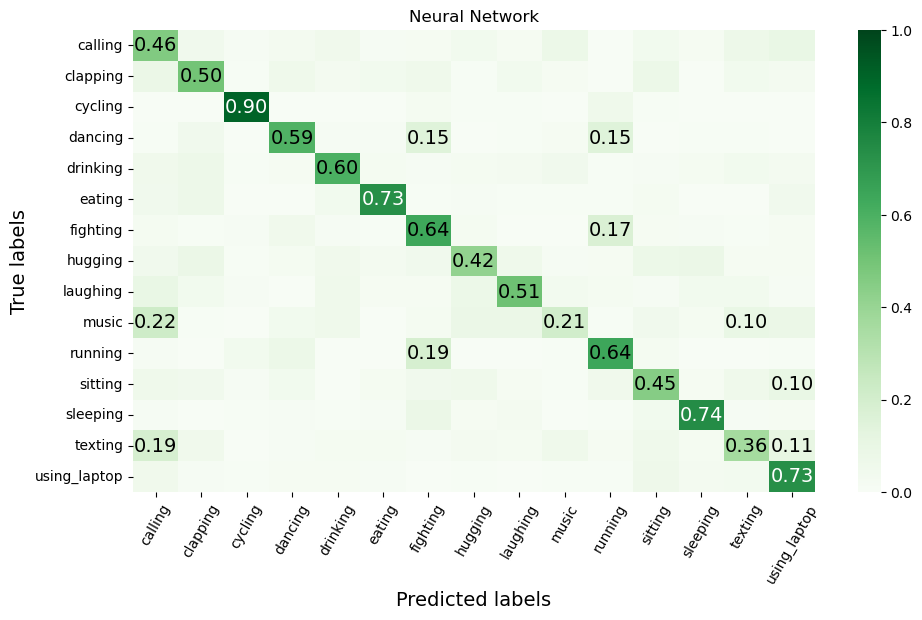

,Accuracy,Sensitivity,Specificity,Precision
calling,0.903571,0.464286,0.934949,0.337662
clapping,0.933730,0.500000,0.964711,0.502994
cycling,0.985317,0.898810,0.991497,0.883041
dancing,0.946825,0.589286,0.972364,0.603659
drinking,0.948810,0.601190,0.973639,0.619632
eating,0.967857,0.732143,0.984694,0.773585
fighting,0.929762,0.636905,0.950680,0.479821
hugging,0.934921,0.416667,0.971939,0.514706
laughing,0.945635,0.511905,0.976616,0.609929
music,0.927778,0.208333,0.979167,0.416667


In [27]:
# Evaluate the model on the test set

test_dataset, _ = create_dataset(test_df, batch_s, use_kpoints=use_kpoints, use_object=use_object)

test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')

# compute predicted labels
output_vector = model.predict(test_dataset)
predicted_labels = np.argmax(output_vector[:,:], axis=1)

extracted_labels = []
for _, label in test_dataset:
    extracted_labels.extend(label.numpy().tolist())

true_labels = np.array(extracted_labels)

# compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plot_confusion_matrix(cm)

test_metrics = class_specific_metrics(cm)
test_metrics

Accuracy = (true positive + true negative) / total

Sensitivity = true positive / (true positive + false negative)

Specificity = true negative / (true negative + false positive)

Precision = true positive / (true positive + false positive)

In [28]:
# helper function
def fitFFNN(file_name, use_kpoints=True, use_object=True):
    
    df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

    # apply the function to the dataframe
    df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
    df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
    df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
    df['category'] = df['category'].apply(lambda x: np.array(x))
    df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
    df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())
    
    print('Loaded dataset ', file_name)
    
    train_df, test_df = train_test_split_df(df, 0.2)

    train_dataset, train_shape = create_dataset(train_df, use_kpoints=use_kpoints, use_object=use_object, batch_size=32)
    test_dataset, test_shape = create_dataset(test_df, use_kpoints=use_kpoints, use_object=use_object, batch_size=32)

    # Create a new instance of the model
    model = create_model(input_shape=train_shape)

    # Train the model
    results = model.fit(train_dataset, epochs=int(avg_epochs), verbose=0)
    
    # compute predicted labels
    output_vector = model.predict(test_dataset)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    extracted_labels = []
    for _, label in test_dataset:
        extracted_labels.extend(label.numpy().tolist())

    true_labels = np.array(extracted_labels)
    
    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Evaluate the model
    val_accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    
    plot_confusion_matrix(cm)
    
    test_metrics = class_specific_metrics(cm)
    print(test_metrics)

    return cm

Loaded dataset  movenet_thunder_mobilenet_large
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.564


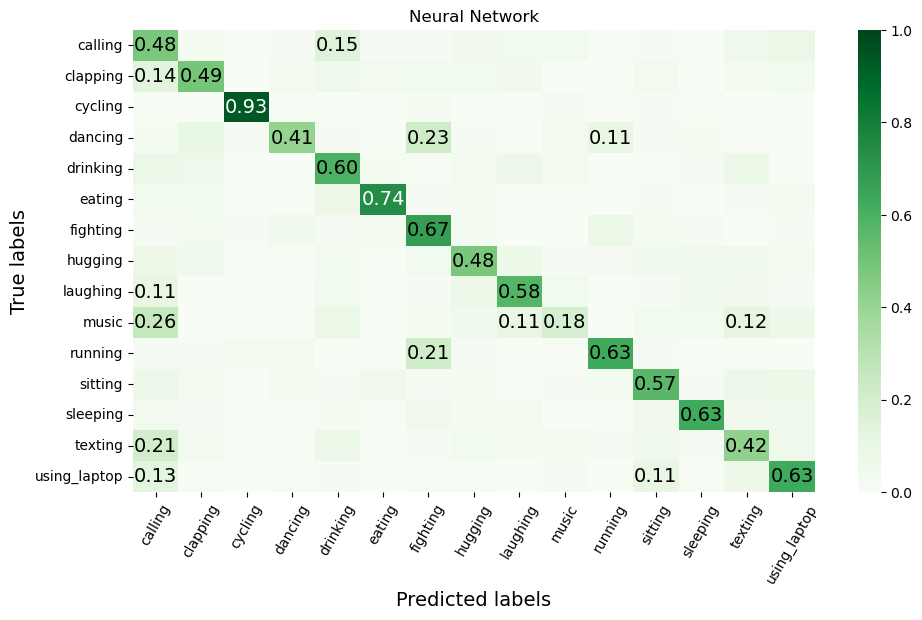

              Accuracy  Sensitivity  Specificity  Precision
calling       0.886111     0.482143     0.914966   0.288256
clapping      0.938889     0.494048     0.970663   0.546053
cycling       0.990079     0.934524     0.994048   0.918129
dancing       0.948016     0.410714     0.986395   0.683168
drinking      0.931349     0.595238     0.955357   0.487805
eating        0.971032     0.744048     0.987245   0.806452
fighting      0.930556     0.672619     0.948980   0.484979
hugging       0.936111     0.482143     0.968537   0.522581
laughing      0.944444     0.577381     0.970663   0.584337
music         0.928571     0.184524     0.981718   0.418919
running       0.958730     0.630952     0.982143   0.716216
sitting       0.940079     0.565476     0.966837   0.549133
sleeping      0.959921     0.630952     0.983418   0.731034
texting       0.920238     0.422619     0.955782   0.405714
using_laptop  0.943651     0.630952     0.965986   0.569892


In [29]:
cm_th_lg = fitFFNN('movenet_thunder_mobilenet_large')

Loaded dataset  movenet_lightning_mobilenet_large
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.548


2024-08-23 17:35:43.725338: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


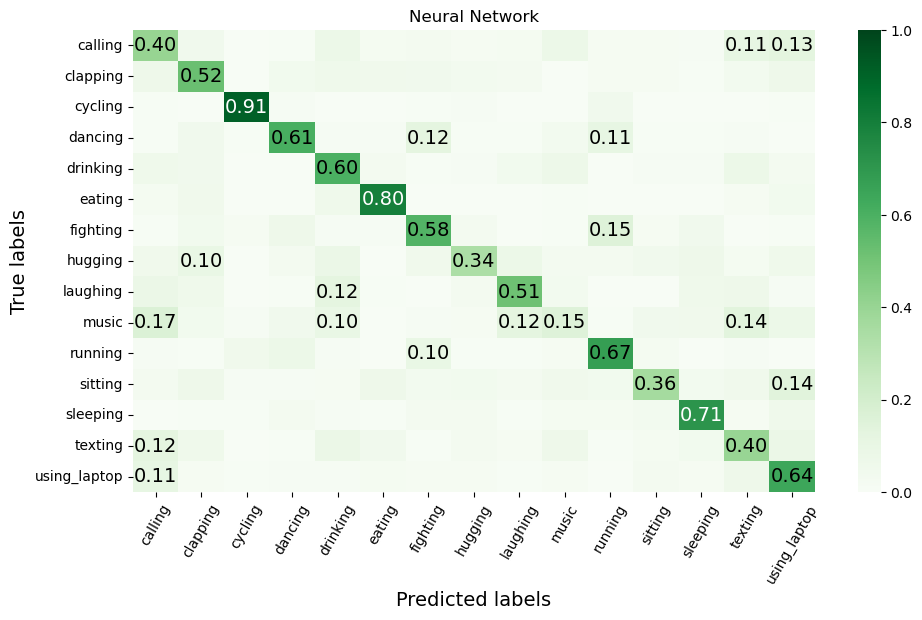

              Accuracy  Sensitivity  Specificity  Precision
calling       0.909921     0.404762     0.946003   0.348718
clapping      0.928571     0.523810     0.957483   0.468085
cycling       0.986508     0.910714     0.991922   0.889535
dancing       0.950794     0.607143     0.975340   0.637500
drinking      0.928571     0.601190     0.951956   0.471963
eating        0.967857     0.797619     0.980017   0.740331
fighting      0.940873     0.583333     0.966412   0.553672
hugging       0.936905     0.339286     0.979592   0.542857
laughing      0.942857     0.511905     0.973639   0.581081
music         0.914286     0.154762     0.968537   0.260000
running       0.947619     0.672619     0.967262   0.594737
sitting       0.938889     0.363095     0.980017   0.564815
sleeping      0.957143     0.714286     0.974490   0.666667
texting       0.917857     0.398810     0.954932   0.387283
using_laptop  0.928175     0.642857     0.948554   0.471616


In [30]:
cm_lh_lg = fitFFNN('movenet_lightning_mobilenet_large')

Loaded dataset  movenet_thunder_mobilenet_small
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.556


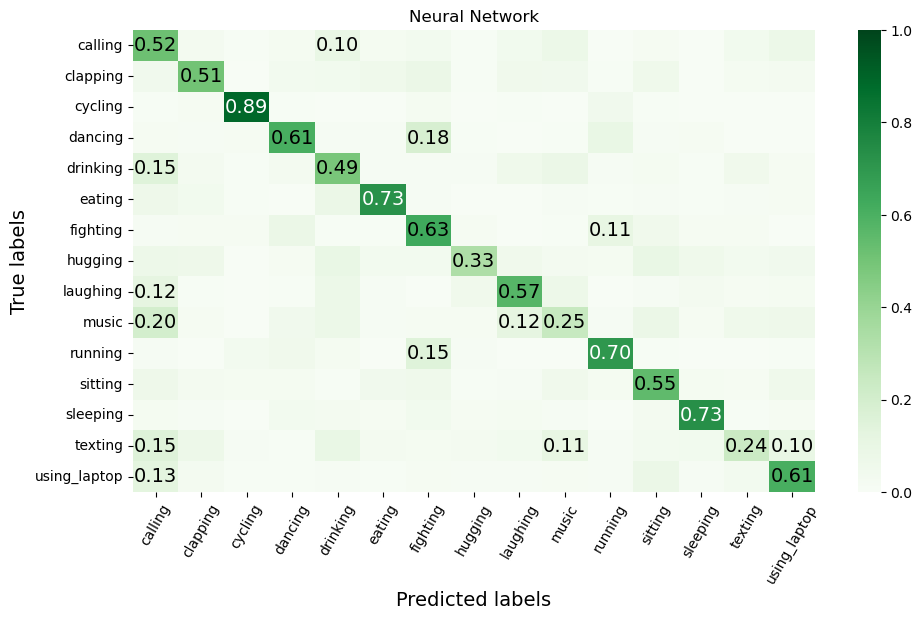

              Accuracy  Sensitivity  Specificity  Precision
calling       0.896032     0.517857     0.923044   0.324627
clapping      0.941667     0.505952     0.972789   0.570470
cycling       0.983730     0.886905     0.990646   0.871345
dancing       0.948413     0.607143     0.972789   0.614458
drinking      0.921825     0.488095     0.952806   0.424870
eating        0.963492     0.726190     0.980442   0.726190
fighting      0.928968     0.630952     0.950255   0.475336
hugging       0.942460     0.333333     0.985969   0.629213
laughing      0.943254     0.571429     0.969813   0.574850
music         0.914683     0.250000     0.962160   0.320611
running       0.956349     0.702381     0.974490   0.662921
sitting       0.934524     0.547619     0.962160   0.508287
sleeping      0.966667     0.732143     0.983418   0.759259
texting       0.927778     0.238095     0.977041   0.425532
using_laptop  0.942857     0.607143     0.966837   0.566667


In [31]:
cm_th_sm = fitFFNN('movenet_thunder_mobilenet_small')

Loaded dataset  movenet_lightning_mobilenet_small
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.523


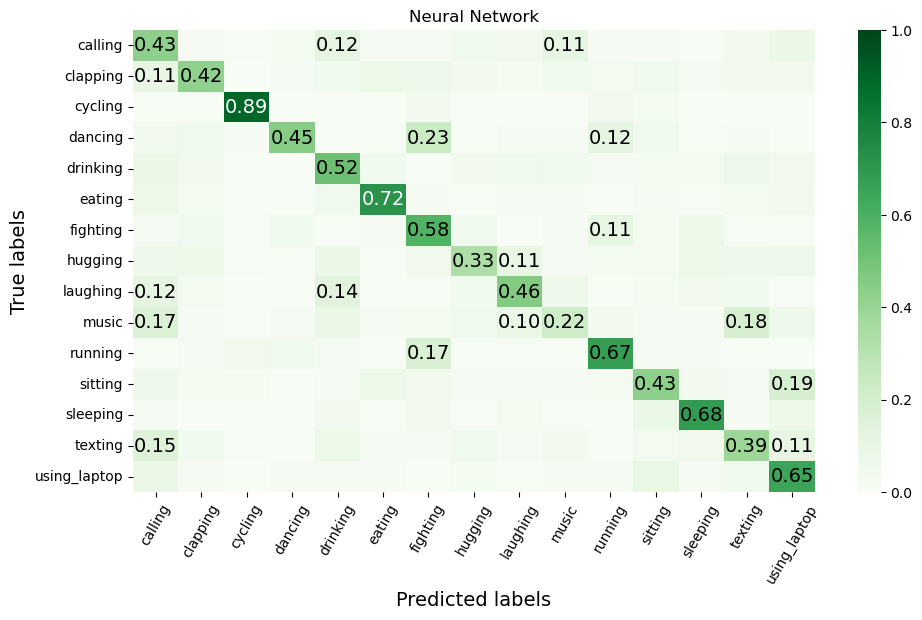

              Accuracy  Sensitivity  Specificity  Precision
calling       0.896825     0.428571     0.930272   0.305085
clapping      0.935714     0.422619     0.972364   0.522059
cycling       0.984524     0.892857     0.991071   0.877193
dancing       0.952381     0.452381     0.988095   0.730769
drinking      0.922222     0.517857     0.951105   0.430693
eating        0.961508     0.720238     0.978741   0.707602
fighting      0.924206     0.583333     0.948554   0.447489
hugging       0.931349     0.333333     0.974065   0.478632
laughing      0.935317     0.458333     0.969388   0.516779
music         0.922619     0.220238     0.972789   0.366337
running       0.948810     0.672619     0.968537   0.604278
sitting       0.928175     0.428571     0.963861   0.458599
sleeping      0.951587     0.684524     0.970663   0.625000
texting       0.923016     0.386905     0.961310   0.416667
using_laptop  0.928571     0.648810     0.948554   0.473913


In [32]:
cm_lh_sm = fitFFNN('movenet_lightning_mobilenet_small')